In [81]:
!pwd 


/uufs/chpc.utah.edu/common/home/u1215181/icepack/notebooks/new_scripts


In [82]:
import firedrake
import icepack

### Read geojson file to get the glacier outlines
Load the geojson file with "r" read only \
List the geojson coordinates with geojson.utils.coords() 

Example:

import geojson \
outline_filename = "mergedfile.geojson"\
with open(outline_filename, "r") as outline_file:\
    outline = geojson.load(outline_file)\
Coord = list(geojson.utils.coords(outline))

In [90]:
import json
with open(outline_filename,'r') as geojson_file:
    geojson_data = json.load(geojson_file)    

### Convert the lat/lon coordinate to UTM, transform degree to meter
Example:
import pyproj\
lat_lon = pyproj.CRS(4326)\
utm8 = pyproj.CRS(32608)\
transformer = pyproj.Transformer.from_crs(lat_lon, utm8)\
print(transformer.transform(coords[0][0], coords[0][1]))\
print(transformer.transform(coords[0][1], coords[0][0]))

In [95]:
import pyproj
# Create a pyproj transformer for the conversion
# WGS 84 (EPSG:4326) is the coordinate system for latitude and longitude
# UTM zone 8N (EPSG:32608) is a common UTM projection for the western United States
wgs84 = pyproj.CRS("EPSG:4326")
utm8 = pyproj.CRS('EPSG:32608')
tansformer = pyproj.Transformer.from_crs(wgs84, utm8)

# Function to convert a single point to UTM
def convert_to_utm(point):
    longitude, latitude = point
    utm_easting, utm_northing = transformer.transform(latitude, longitude)
    return utm_easting, utm_northing

# Function to convert a list of points to UTM
def convert_polygon_to_utm(polygon):
    utm_polygon = []
    for ring in polygon:
        utm_ring = [convert_to_utm(point) for point in ring]
        utm_polygon.append(utm_ring)
    return utm_polygon

# Extract the coordinates from the GeoJSON data
# Access the feature key in the GeoJSON data
features = geojson_data.get('features',[])
# Iterate through the features
for feature in features:
    # get the 'geometry' key to eatch feeatures
    geometry = feature.get('geometry',{})
    # access the 'coordinate' key in the geometry
    coordinates = geometry.get('coordinates',[])
    #print(coordinates)
    utm_coordinates = convert_polygon_to_utm(coordinates)
    print(utm_coordinates)

[[(-311095.3011005287, 7093171.458872312), (-311223.2346915731, 7093676.794206937), (-311514.1001729424, 7093951.100800679), (-311919.6649011314, 7094278.61375997), (-311992.75092006626, 7094842.147575389), (-312119.0442588697, 7095290.995451065), (-312288.60628767847, 7095286.02500029), (-312735.7989736225, 7095103.203062121), (-313008.4501821955, 7094755.789392651), (-313284.41302565136, 7094521.4145287555), (-313676.7308606049, 7094396.756076452), (-313896.1662696708, 7094164.035867349), (-314163.8086395286, 7093647.060050007)]]
[[(-314140.54204843775, 7092855.814540366), (-313673.4577094682, 7092360.46368704), (-313537.16801945213, 7091572.582105987), (-313618.6172108676, 7090495.517407429), (-314414.7737654755, 7090641.77053942), (-314863.5435900468, 7090515.431313864), (-315338.8325563574, 7089370.215776904), (-315877.2512227467, 7088449.393317966), (-316651.67640765454, 7087860.945885263), (-317547.4453958799, 7087551.672597826), (-318087.42380250664, 7086687.342005733), (-31867

In [92]:
print(geojson_data["crs"]["properties"]["name"])

urn:ogc:def:crs:OGC:1.3:CRS84


In [29]:
import numpy as np

δ = 50e3
coords = np.array(list(geojson.utils.coords(outline)))
xmin, xmax = coords[:, 0].min() - δ, coords[:, 0].max() + δ
ymin, ymax = coords[:, 1].min() - δ, coords[:, 1].max() + δ

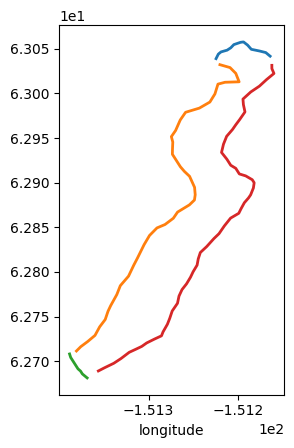

In [30]:
import icepack.plot

fig, axes = icepack.plot.subplots()

for feature in outline["features"]:
    for line_string in feature["geometry"]["coordinates"]:
        xs = np.array(line_string)
        axes.plot(xs[:, 0], xs[:, 1], linewidth=2)

axes.set_xlabel("longitude");

Initial mesh generation.

In [31]:
from meshpy import triangle

In [32]:
geometry = icepack.meshing.collection_to_triangle(outline)

In [33]:
triangle_mesh = triangle.build(geometry, max_volume=4e-5)

In [34]:
mesh = icepack.meshing.triangle_to_firedrake(triangle_mesh)

In [35]:
Q = firedrake.FunctionSpace(mesh, "CG", 2)
V = firedrake.VectorFunctionSpace(mesh, "CG", 2)

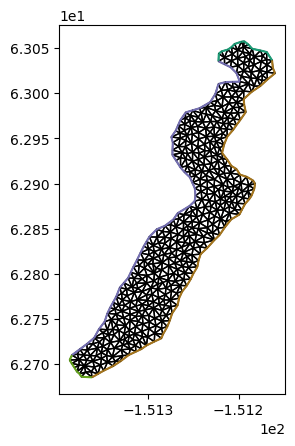

In [36]:
fig, axes = icepack.plot.subplots()
firedrake.triplot(mesh, axes=axes)
#axes.legend()

In [37]:
S = firedrake.FunctionSpace(mesh, "DG", 0)
areas = firedrake.project(firedrake.CellVolume(mesh), S)

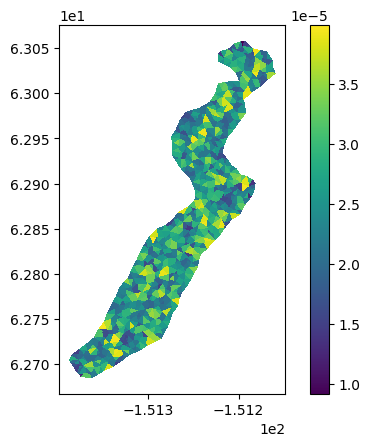

In [38]:
fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(areas, axes=axes)
fig.colorbar(colors);

Mesh refinement.

In [39]:
x = firedrake.SpatialCoordinate(mesh)
expr = firedrake.conditional(
    x[1] <= 62.9,
    areas / 2,
    areas
)
desired_areas = firedrake.project(expr, S)

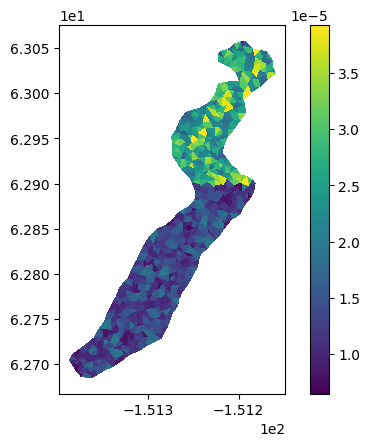

In [40]:
fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(desired_areas, axes=axes)
fig.colorbar(colors);

In [41]:
triangle_mesh.element_volumes.setup()
for index, area in enumerate(desired_areas.dat.data_ro):
    triangle_mesh.element_volumes[index] = area

In [42]:
refined_triangle_mesh = triangle.refine(triangle_mesh)

In [43]:
fine_mesh = icepack.meshing.triangle_to_firedrake(refined_triangle_mesh)

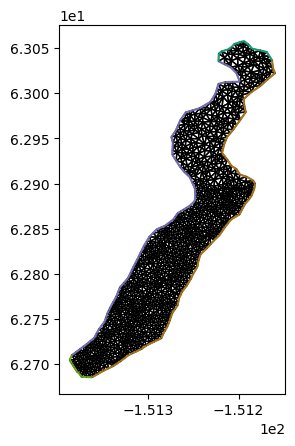

In [44]:
fig, axes = icepack.plot.subplots()
firedrake.triplot(fine_mesh, axes=axes);